In [1]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from scipy.stats import norm, ttest_ind

In [2]:
def plot_pvalue_ecdf(pvalues: float, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

# Task description

**Task 3: Data Insights**
You are tasked with helping the Supply Product team to better understand user interaction,
metrics and engagement of FREENOW drivers:

**3.Freenow_drivers_campaign**

A summary of the campaign data including:
- ***Driver:*** the driver identification number in the test (different from previous id_driver, don't
try to join it)
- ***Rides_within_week:*** number of rides completed within one week after the update
- ***Test_group:*** Group that the driver was inserted in the email campaign.

**Expected Deliverables**
On a separate initiative, the team wanted to find out if a certain email campaign works to
incentivise the drivers to be more active in our platform. To do so we divided the drivers in
two groups A and B. Group B received an email informing drivers of when we expect high
customer demand in the following week. Group A did not receive the email. Please find
out about the effect of the campaign. Explain how you determine the impact and why you
chose such a method to evaluate it.

# Settings

In [3]:
sns.set_theme()

# Data mining

In [4]:
try:
    camp = pd.read_csv("CSVs/freenow_driver_campaign.csv")
except FileNotFoundError:
    camp = pd.read_clipboard()

camp = camp.reset_index()
camp.columns = ['driver', 'rides_within_week', 'test_group']
camp = camp.drop(0).reset_index(drop=True)
camp['rides_within_week'] = camp['rides_within_week'].astype(int)
assert len(camp) == 10000, 'should be 10000 rows'
assert camp['driver'].count() == 10000, 'should be 10000 total'
assert camp['rides_within_week'].sum() == 510809, 'should be 510809 total'
assert camp['test_group'].nunique() == 2, 'should be 2 total'

camp.head()

,driver,rides_within_week,test_group
0,1,88,A
1,2,56,B
2,3,80,B
3,4,49,A
4,5,61,A


In [5]:
primary_key = ['driver','test_group']
assert camp.set_index(primary_key).index.is_unique, 'found duplicates'

In [6]:
camp.describe()

,rides_within_week
count,10000.000000
mean,51.080900
std,18.869016
min,0.000000
25%,38.000000
50%,51.000000
75%,64.000000
max,120.000000


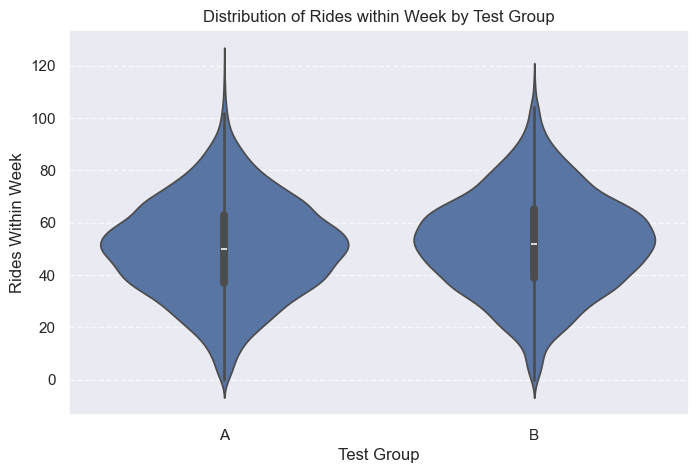

In [7]:
plt.figure(figsize=(8, 5))
sns.violinplot(x="test_group", y="rides_within_week", data=camp)

plt.title("Distribution of Rides within Week by Test Group")
plt.xlabel("Test Group")
plt.ylabel("Rides Within Week")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [8]:
# number of users in each groups
camp['test_group'].value_counts()

test_group
A    5000
B    5000
Name: count, dtype: int64

In [9]:
# average for in each groups
camp.groupby(['test_group']).agg({'rides_within_week': 'mean'}).reset_index()

,test_group,rides_within_week
0,A,50.0450
1,B,52.1168


In [10]:
data_control = camp[camp['test_group'] == 'A']['rides_within_week']
data_pilot = camp[camp['test_group'] == 'B']['rides_within_week']
pvalue = float(stats.ttest_ind(data_control, data_pilot).pvalue)
print(f"{pvalue:.8f}")

0.00000004


In [11]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

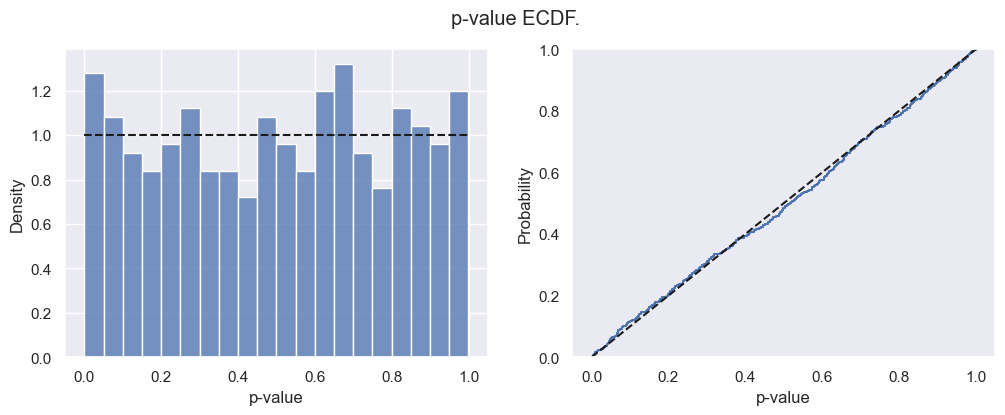

In [12]:
p_values = []
users = camp['driver'].unique()
for _ in range(500):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
    sales_a = camp[camp['driver'].isin(group_a)]['rides_within_week']
    sales_b = camp[camp['driver'].isin(group_b)]['rides_within_week']
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF.')

In [13]:
print(f"{(np.array(p_values) < 0.05).mean():.3f}")

0.064


It is evident that the p-value is not uniformly distributed. This implies that if we were to naively apply a t-test to this sample, we would make errors at a significance level of 0.05 with a probability exceeding 0.05. Consequently, we would, on average, observe twice as many false positives as permitted by the experimental design.